# Sensor Monitoring with Strip Charts

## Introduction

I decided to extend the sensor monitoring I described earlier (measuring light levels), to an experiment where two environment variables were measured.  I wanted  the monitoring GUI to included strip charts, to display the history of the variables.

Along the way, I found getting strip charts exactly as I wanted them to be tricky, and I found Seaborn a little unsatisifying for visualization of two (unrelated) variables - I will explain why below.  I also measured just how steamy my bathroom gets!

---
## Notebook setup

```watermark``` documents the Python environment, ```black``` is my chosen formatter

In [1]:
%load_ext watermark
%load_ext lab_black

The bottom block of imports is just to support Python environment documentation

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns

import datetime

import sys
import os
import subprocess
import datetime
import platform
import datetime

----
## Hardware Setup

The diagram below show my hardware setup.  I used an I2C board to drive my LCD display.  The DHT22 sensor measures both temperature and relative humidity.

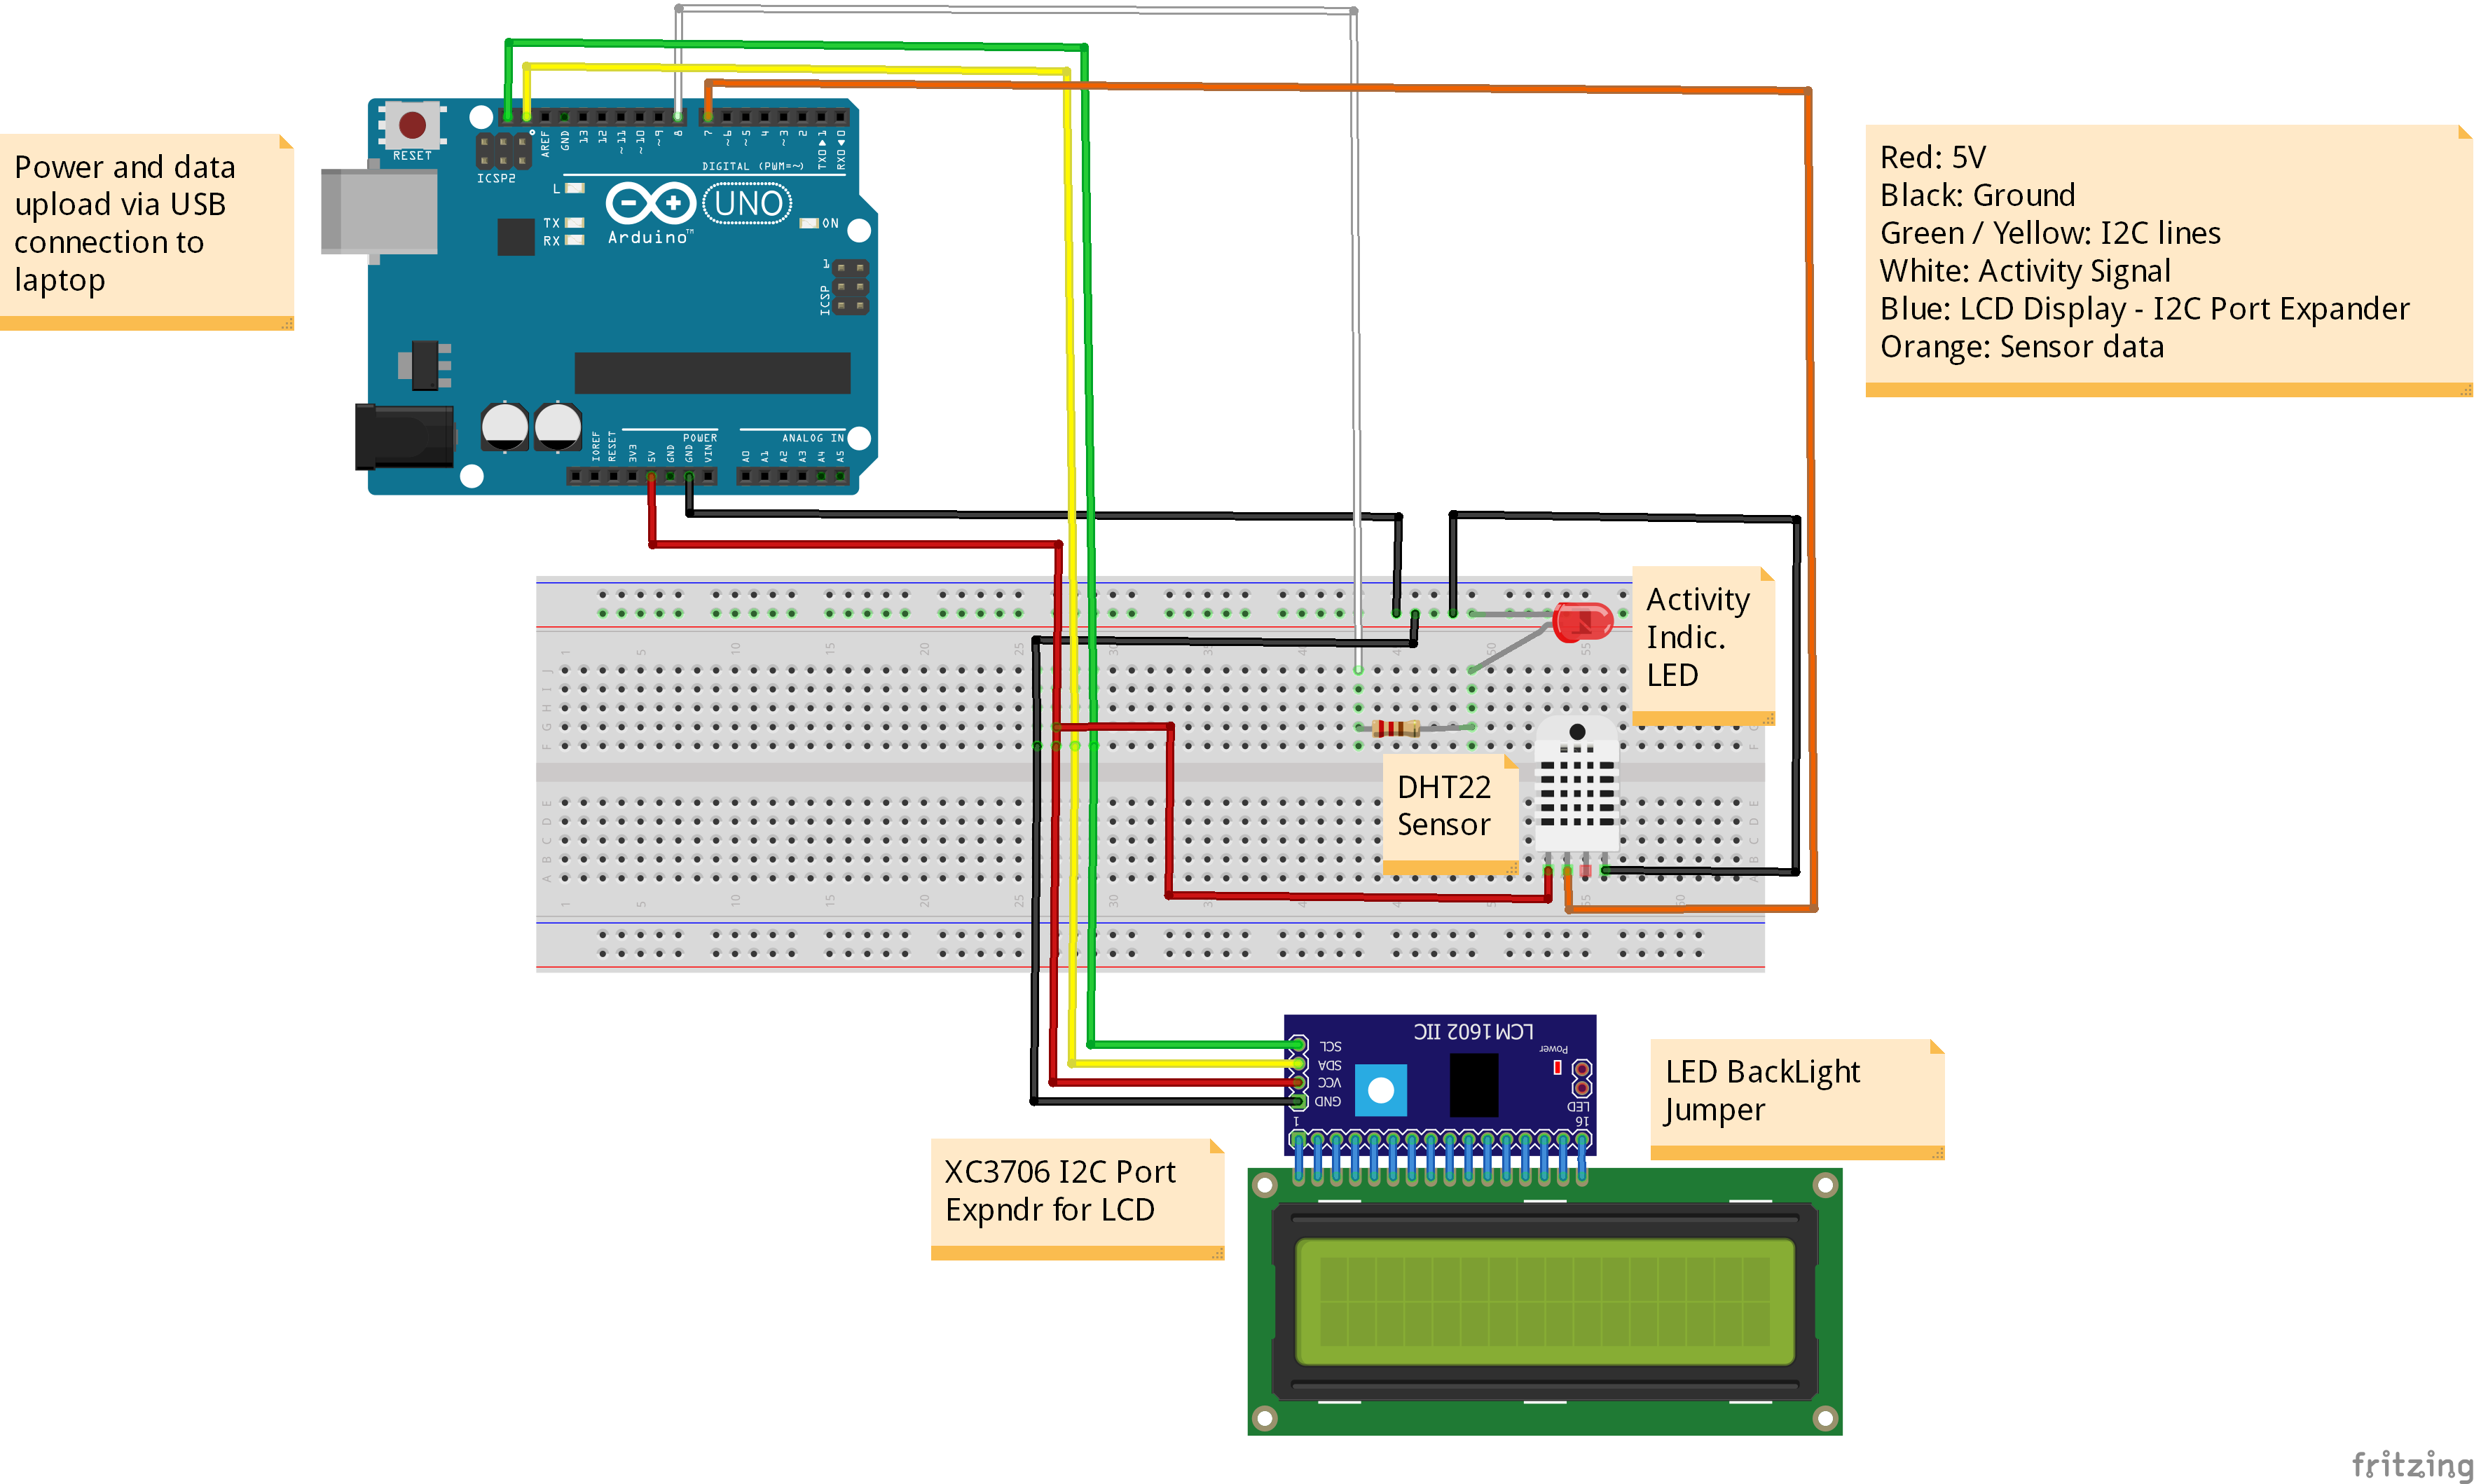

In [3]:
from IPython.display import Image

Image("images/TempHumDisplay_bb.png")

---
## Arduino Sketch


The code below is that of my Arduino Sketch.  Because I am using a I2C bus to drive my LCD, i need a library for that.  I also need a library to drive my DHT22 sensor.

I choose to put the activity LED on for 400 milliseconds, do a sensor reading, drive the LCD display, write up the serial line,  and then wait for 2,600 miliseconds for the next reading.
```c
// Libraries

#include <LiquidCrystal_PCF8574.h>
#include <Wire.h>
#include <DHT.h>

LiquidCrystal_PCF8574 lcd(0x27); // set the LCD address to 0x27 for a 16 chars and 2 line display

// pin used to blink activity LED
int led = 8;
int READINGBLINKTIME = 400;  // millisecs, time to flash LED when reading done
int TIMEBETWEENREADING = 2600; // millisecs, time between sensor readings
```

Configure the Sensor

```c
// Constants for Temp / Hum sensor

#define DHTPIN 7
#define DHTTYPE DHT22

DHT dht(DHTPIN, DHTTYPE); // create sensor object

int chk;
float hum;  // humidty sensor value
float tmp;  // temperature sensor value
```

In setup, we configure the port used to drive the activity led, and we configure the serial line, and configure the I2C bus looking for a LCD 16 X 2 display.
It turns out that the Arduino board I am using has an activity LED for serial reads/ writes, but I feel happier with an activity LED under my control.

We choose to do no error checking on the serial line, but just wait for the line to come up.

If we can't find an LCD display, we blink our activity LED to indicate an error condition 
(because of my less-than-expert soldering skills, this was actually tested)

```c
void setup()
{
  // used for activity signal
  pinMode(led, OUTPUT);

  // Start writing to Serial Line in this version of program
  //
  Serial.begin(38400);
  // supress all  but data for automated logging
  // Serial.println("LCD Temp/ Hum Sensor ...");

  // wait on Serial to be available on Arduino
  while (!Serial)
    ;

  // Serial.println("Startup: checking for LCD ...");

  // See http://playground.arduino.cc/Main/I2cScanner how to test for a I2C device.

  int error;  // holds I2C response
  
  Wire.begin();
  Wire.beginTransmission(0x27);
  error = Wire.endTransmission();

  if (error == 0) {
    // LCD Found
    lcd.begin(16, 2); // initialize the lcd

    dht.begin(); // initialize sensor

  } else {
    Serial.println(": LCD not found.");
    // rapidly flash LED to show error
    while( true){
      digitalWrite(led, HIGH);
      delay(100);
      digitalWrite(led, LOW);
    };//end while
  
  } // if

} // setup()
```

In the Do-Forever loop, we light up our activity LED, make sure the LCD Display is set the way we want it, 
get the sensor readings, format them for the LCD Display, and write to the LCD Display.

Then we write to the serial line (via USB to my laptop), wait for the activity LED to be noticable, and turn it off again.

```c
// count not yet used
int count = 0;

// character buffers for formatted sensor readings
static char outstrTemp[7] = "      ";
static char outstrHumd[6] = "     ";

void loop()
{ 
  count = count+1;
  // set activity LED high
  digitalWrite(led, HIGH);

  // make backlight bright
  lcd.setBacklight(255);
  lcd.home();
  // display line 1
  lcd.clear();
  lcd.print("Temp &  Humidity");

  lcd.setCursor(0, 1);

  // read sensor
  hum = dht.readHumidity();
  tmp = dht.readTemperature();

  // format readings (temp can be -ve, humidity always positive (?)
  // sign +3 digit temp + . + digit = 6 characters 
  dtostrf(tmp, 6, 1, outstrTemp);
   // 3 digit humidity + . + digit = 5 chars
  dtostrf(hum, 5, 1, outstrHumd);

  // write to lcd display, line 1 (of 0, 1. so bottom line)
  lcd.print(outstrTemp);
  lcd.print("C ");
  lcd.print(outstrHumd);
  lcd.print("%");

  // write to serial line

  Serial.print(tmp, DEC);
  Serial.print(", ");
  Serial.println(hum, DEC);
  
  delay(READINGBLINKTIME);

  digitalWrite(led, LOW);
  delay(TIMEBETWEENREADING);
  
} // loop()
```

---
## Logging and GUI Notebook

The Python code for the GUI and datalogger is below.  We use ```PySimpleGUI``` to build our GUI.  Because I am drawing strip charts, we need to import some extra packages from ```matplotlib```.  ```Pathlib``` is used to create the logging file.

```python
# pysimplegui build the Windows UI
import PySimpleGUI as sg      

# import serial comms package
import serial
import serial.tools.list_ports as list_ports

import time
import datetime

from pathlib import Path

# used for initial testing
from random import randint

# import objects to support plotting on GUI
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, FigureCanvasAgg
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
```

Define a helper routine to show serial line status

```python
def show_ports():
    '''
    show_ports: show available ports for serial communications
    
    Parameters:
    None
    
    Returns:
    None
    
    Side Effects:
    prints to standard output, one line per port
    '''
    ports = list(list_ports.comports() )
    _ = [print(p) for p in ports]
    return None
    
#end show_ports
```

Define a helper routine to draw matplotlib graphics on the GUI

```python
def draw_figure(canvas, figure, loc=(0, 0)):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg
#end draw_figure
```

Create a unique file name for our logging

```python
#
# get unique name for log file
#
LOGGING_PATH = '/ArduinoLogging/TempHumd/'
now = str(datetime.datetime.now())
now_name = now[0:10] + '-' + now[11:13] + now[14:16] + now[17:19] + '.csv'
print('Log File Name: ', now_name,)

log_path = Path(LOGGING_PATH + now_name)
if ( log_path.exists () ):
    pass
else:
    # create file if needed (should always be needed)
    f = log_path.open(mode='x')
    f.close()
#end if
```

The definition of our GUI now includes two ```Canvas``` Objects, that will hold our ```matplotlib``` charts.  We  also have a vertical bar for each sensor variable, and text display of the latest reading.

I choose to use the ```matplotlib``` defaults for labelling the X and Y axis tick marks, but ```matplotlib``` default labels for date-times frequently overlap, so I chose to rotate them by 90 degrees.  Getting this to stick, between the interactions of the ```Canvas```, ```Axes```, and ```Figure``` object was tricky: sometimes the rotated labels were truncated. I discovered setting the properities of the Axes Object to be the secret, by ```plt.setp(ax2.get_xticklabels(), rotation=90)```.

```python
# screen update rate millisecs
SCREEN_READ_PERIOD = 50


#
# define GUI to show temperature and humidty levels
# bar is 30 (default font) chars wide, 100 pixels high

figure_width = 5 # inch
figure_height = 4 # inch

col1 = [ [sg.Text("Temp. (C)   ", size=(12,1), font=("Helvetica", 50), key='Temp0',)],
         [sg.ProgressBar(100, orientation='v', size=(30,100), key='tpbar',), 
            sg.Canvas(size=(figure_width,figure_width), key='canvas1')],
         [sg.Text(str(23), size=(5,1), font=("Helvetica", 50), key='Temp',)], ]

col2 = [ [sg.Text("Humd. (%)   ", size=(12,1), font=("Helvetica", 50), key='Humd0',)],
         [sg.ProgressBar(100, orientation='v', size=(30,100), key='hpbar',), 
            sg.Canvas(size=(figure_width,figure_width), key='canvas2')],
         [sg.Text(str(23), size=(5,1), font=("Helvetica", 50), key='Humd',)], ]

layout = [      [sg.Text('Temp. & Humd. Meter', size=(12,1), font=("Helvetica", 50))],     
                 [sg.Column(col1), sg.Column(col2)],
                [sg.Cancel()]
         ]      

window = sg.Window('Temp Meter', layout,)
window.Finalize()
progress_bar1 = window['tpbar']
progress_bar2 = window['hpbar']

canvas_elem1 = window['canvas1']
canvas1 = canvas_elem1.TKCanvas

canvas_elem2 = window['canvas2']
canvas2 = canvas_elem2.TKCanvas

# draw the initial plot in the temp strip chart
fig1 = Figure(figsize=(figure_width, figure_height))
ax1 = fig1.add_subplot(111)
ax1.set_xlabel("X axis")
ax1.set_ylabel("Y axis")
fig1.autofmt_xdate(rotation=90)

ax1.grid()
fig_agg1 = draw_figure(canvas1, fig1)

# draw the initial plot in the humidity strip chart
fig2 = Figure(figsize=(figure_width, figure_height))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel("X axis")
ax2.set_ylabel("Y axis")
fig2.autofmt_xdate(rotation=90)

ax2.grid()
fig_agg2 = draw_figure(canvas2, fig2)


```

In our Do-Forever loop, we check for a user Cancel request, then read the serial line: if data has been read, we update the GUI.  
We then wait for a time (less than the update period from the Arduino).

In the code below, I chose to display all values ever read, but a sliding window could have been used.

```python
#
#  Set up Serial Port
show_ports()
#  serial_port = setup_comms_port()
with serial.Serial(port="com7", baudrate=38400,) as serial_port:
    serial_string = ''
    serial_port.reset_input_buffer()
    
    # open logging file with auto close
    with log_path.open(mode='a') as f:

        x_coords = []
        y_coords1 = []
        y_coords2 = []

        for i in range(1,1000000):
            # read values from serial port, and show in screen
            event, values = window.read(timeout=SCREEN_READ_PERIOD,)    

            # check for user exit
            if( event=='Cancel' or event is None):
                
                # user want us to quit logging
                break
            #end if
            
            # read values from serial port, and show in screen
            if(serial_port.in_waiting > 0):
                serial_string = serial_port.readline()
                serial_string = serial_string.decode('ascii')
                
                # get temp and humidty values from serial line
                values = serial_string.split(',')
                value1 = float(values[0])
                value2 = float(values[1])
                
                # update GUI display
                window['Temp'].update(f'{value1:>5.1f}')
                window['Humd'].update(f'{value2:>5.1f}')
                progress_bar1.UpdateBar(value1)
                progress_bar2.UpdateBar(value2)
                
                # update strip charts
                x_coords.append(datetime.datetime.now())
                y_coords1.append(value1)
                y_coords2.append(value2)

                ax1.cla()                    # clear the subplot
                ax1.grid()                   # draw the grid

                # only show all , or the selected plot_points in graph
                plot_end = len(x_coords)
                plot_points = 40
                plot_start = 0 # max(0, plot_end-plot_points)

                ax1.plot(x_coords[plot_start:plot_end+1], y_coords1[plot_start:plot_end+1],  color='red')

                plt.setp(ax1.get_xticklabels(), rotation=90)

                fig_agg1.draw()

                ax2.cla()                    # clear the subplot
                ax2.grid()                   # draw the grid

                ax2.plot(x_coords[plot_start:plot_end+1], y_coords2[plot_start:plot_end+1],  color='green')

                plt.setp(ax2.get_xticklabels(), rotation=90)

                fig_agg2.draw()
                
                # log new data
                f.write(str(datetime.datetime.now()) + ' , ' + 
                        str(value1) + ', ' + str(value2) +'\n')


            else:
                # no data to read, so wait (for less time than sensor
                # delays before writes to serial line)
                time.sleep(0.5)
            #end if

        #end for

window.close()
```

--------------
## Monitoring GUI

The resulting GUI looks like that below

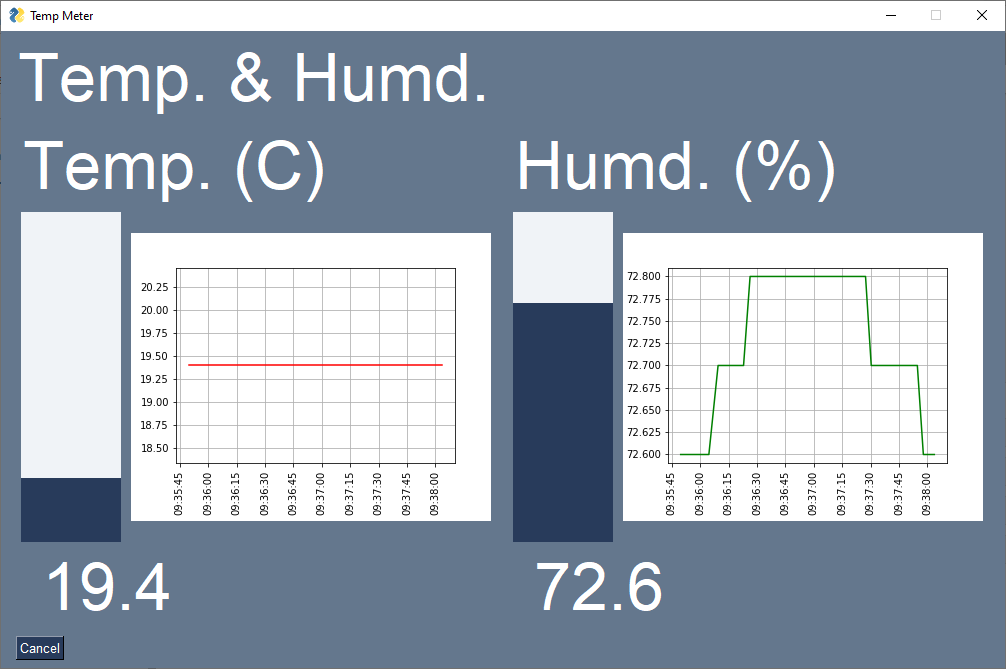

In [4]:
from IPython.display import Image

Image("images/GUISnapshot.png")

----
## Hardware Prototype

The monitoring GUI in operation.  Note the LCD display and laptop GUI concur.

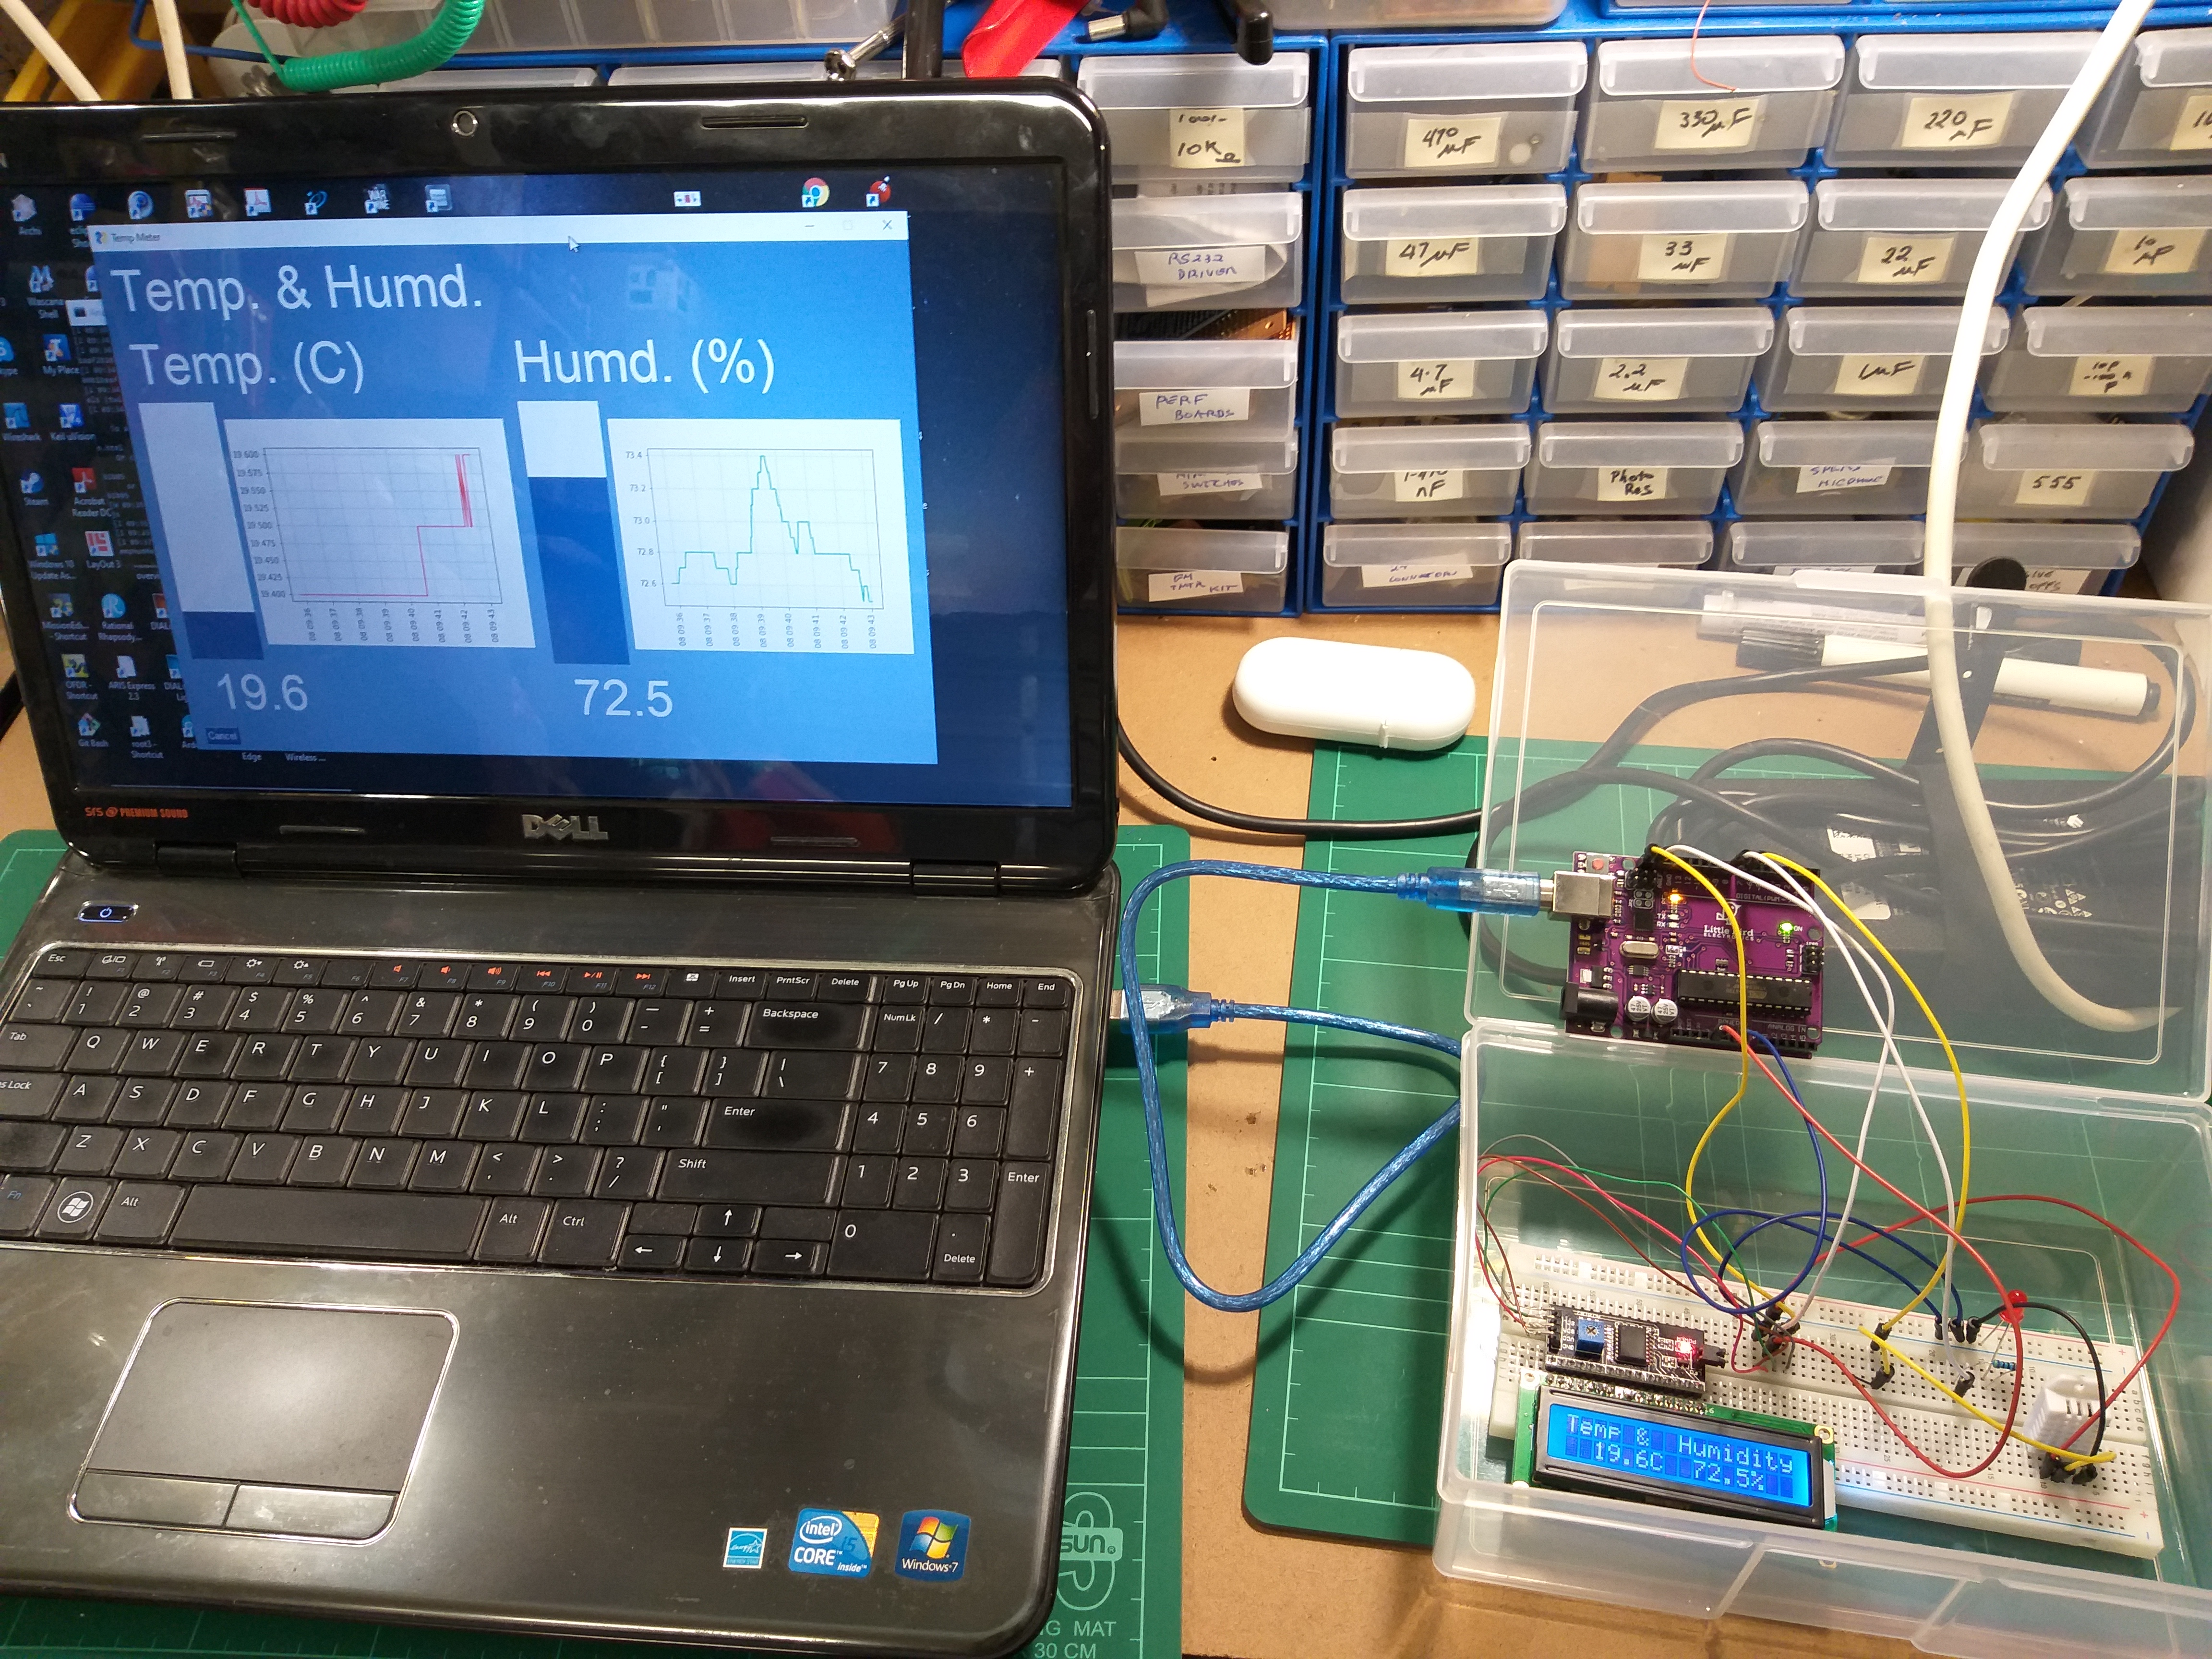

In [5]:
from IPython.display import Image

Image("images/prototype.jpg")

---------------
## Visualizing Logged Data

So I decided to measure the temperature and humidity when I took a shower, and visualize the results

### Read and Clean Dataset

We have to convert datetime strings into datetime objects

In [6]:
data = pd.read_csv(
    '2020-06-08-090033.csv',
    names=['Time', 'Temperature', 'Humidity'],
)
data.head()

Time  Temperature   Humidity
0  2020-06-08 09:00:39.435997     19.300001  74.099998
1  2020-06-08 09:00:41.818909     19.400000  74.200005
2  2020-06-08 09:00:45.356689     19.400000  74.200005
3  2020-06-08 09:00:48.311527     19.400000  74.200005
4  2020-06-08 09:00:51.182438     19.400000  74.099998

In [7]:
data.dtypes

Time            object
Temperature    float64
Humidity       float64
dtype: object

In [8]:
data['Time'] = pd.to_datetime(
    data['Time'], format='%Y-%m-%d %H:%M:%S.%f'
)

In [9]:
data.dtypes

Time           datetime64[ns]
Temperature           float64
Humidity              float64
dtype: object

In [10]:
data.head()

Time  Temperature   Humidity
0 2020-06-08 09:00:39.435997    19.300001  74.099998
1 2020-06-08 09:00:41.818909    19.400000  74.200005
2 2020-06-08 09:00:45.356689    19.400000  74.200005
3 2020-06-08 09:00:48.311527    19.400000  74.200005
4 2020-06-08 09:00:51.182438    19.400000  74.099998

### Visualizations'

We can use the quick-and-dirty methods in ```pandas``` to show the data

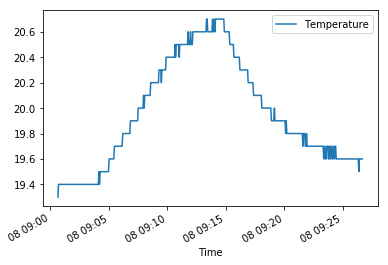

In [11]:
data.plot('Time', 'Temperature', kind='line')

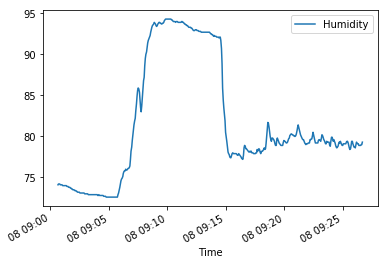

In [12]:
data.plot('Time', 'Humidity', kind='line')

### Combined Plots

We can use the ```Axes-cloning``` technique to show both enironmental variables on the one chart.  We add an annotation to show a change in the environment conditions.

Text(0.5, 0, 'Time (in 2020-06-08)')

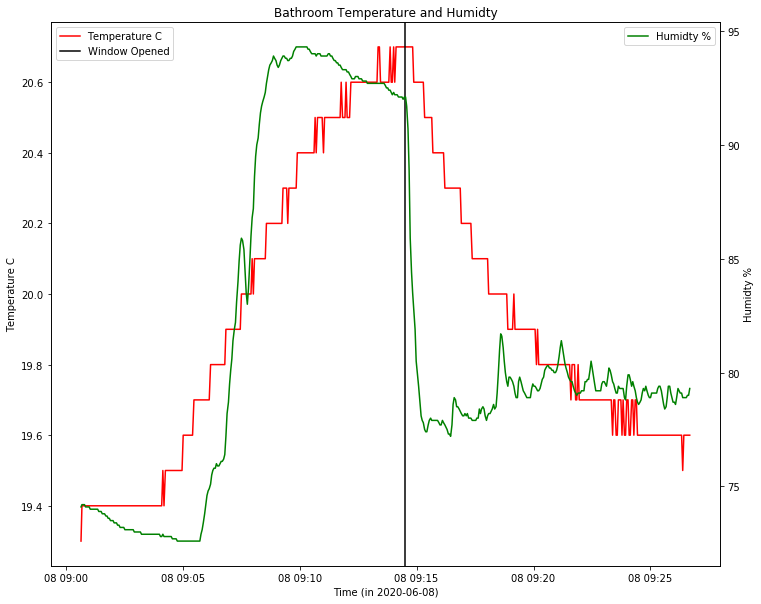

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))

# plot temperature
ax.plot(
    data['Time'],
    data['Temperature'],
    'r-',
    label='Temperature C',
)

# plot humidity
ax2 = ax.twinx()
ax2.plot(
    data['Time'], data['Humidity'], 'g-', label='Humidty %'
)

# label y axis 1 and 2
ax2.set_ylabel('Humidty %')
ax.set_ylabel('Temperature C')

# show event
ax.axvline(
    datetime.datetime(
        year=2020,
        month=6,
        day=8,
        hour=9,
        minute=14,
        second=30,
    ),
    color='black',
    label='Window Opened',
)

# set legends position to match y axis
ax2.legend(loc='upper right')
ax.legend(loc='upper left')

ax.set_title('Bathroom Temperature and Humidty')

ax.set_xlabel('Time (in 2020-06-08)')

We define a function to do our plotting, and use this to look at different styles

In [14]:
def two_line_plot():
    fig, ax = plt.subplots(figsize=(12, 10))

    # plot temperature
    ax.plot(
        data['Time'],
        data['Temperature'],
        'r-',
        label='Temperature C',
    )

    # plot humidity
    ax2 = ax.twinx()
    ax2.plot(
        data['Time'],
        data['Humidity'],
        'g-',
        label='Humidty %',
    )

    # label y axis 1 and 2
    ax2.set_ylabel('Humidty %')
    ax.set_ylabel('Temperature C')

    # show event
    ax.axvline(
        datetime.datetime(
            year=2020,
            month=6,
            day=8,
            hour=9,
            minute=14,
            second=30,
        ),
        color='orange',
        label='Window Opened',
    )

    # set legends position to match y axis
    ax2.legend(loc='upper right')
    ax.legend(loc='upper left')

    ax.set_title('Bathroom Temperature and Humidty')

    ax.set_xlabel('Time (in 2020-06-08)')

Using the ```dark_background``` style

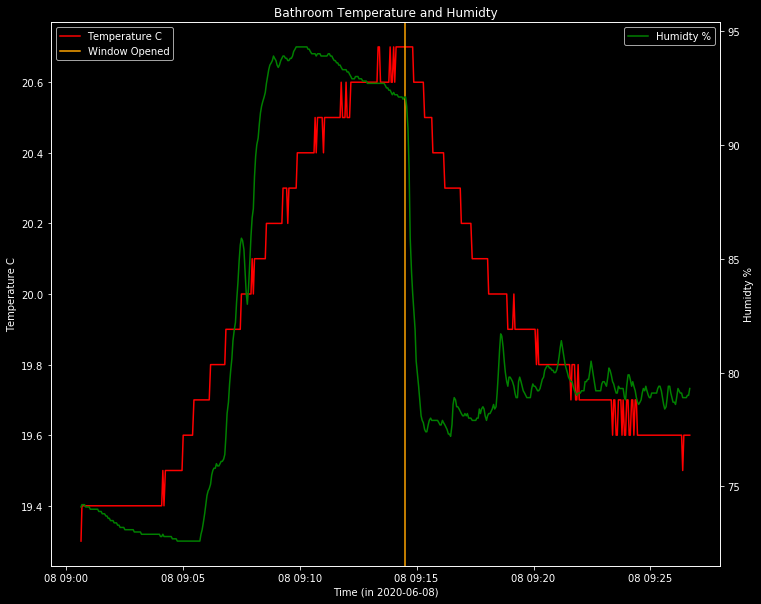

In [15]:
with plt.style.context('dark_background'):
    two_line_plot()

Just for fun, using the ```xkcd``` style

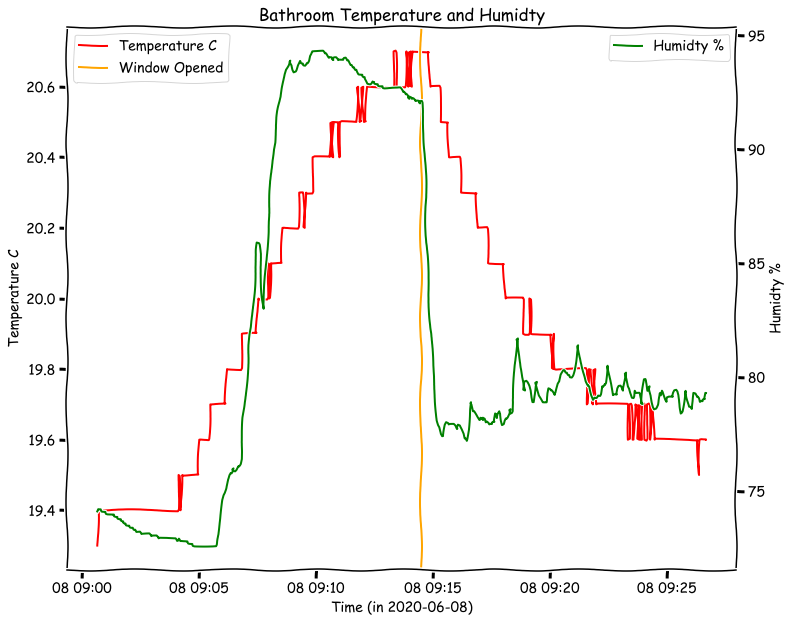

In [16]:
with plt.xkcd():
    two_line_plot()

I found the Seaborn style a little jarring, with the grid being drawn from both Y axis leading to a little confusion on my part

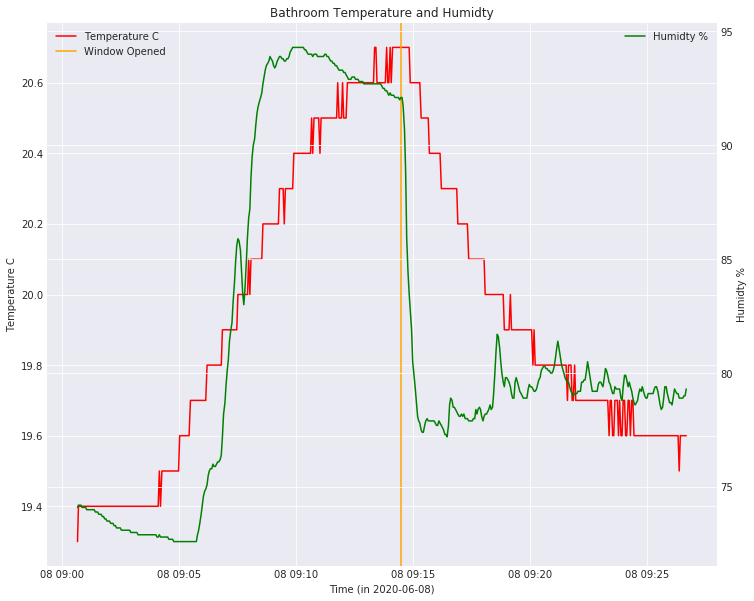

In [17]:
with plt.style.context('seaborn-darkgrid'):
    two_line_plot()

----
## Notebook Environment

In [18]:
%watermark

%watermark -h -iv

2020-06-10T11:08:37+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
pandas     1.0.0
matplotlib 3.0.2
seaborn    0.9.0
platform   1.0.8
host name: DESKTOP-SODFUN6


In [19]:
# show info to support reproducibility

theNotebook = 'PlotTempHumd.ipynb'


def python_env_name():
    envs = subprocess.check_output(
        'conda env list'
    ).splitlines()
    # get unicode version of binary subprocess output
    envu = [x.decode('ascii') for x in envs]
    active_env = list(
        filter(lambda s: '*' in str(s), envu)
    )[0]
    env_name = str(active_env).split()[0]
    return env_name


# end python_env_name

print('python version     : ' + sys.version)
print('python environment :', python_env_name())

print('current wkg dir    : ' + os.getcwd())
print('Notebook name      : ' + theNotebook)
print(
    'Notebook run at    : '
    + str(datetime.datetime.now())
    + ' local time'
)
print(
    'Notebook run at    : '
    + str(datetime.datetime.utcnow())
    + ' UTC'
)
print('Notebook run on    : ' + platform.platform())

python version     : 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
python environment : ac5-py37
current wkg dir    : C:\Users\donrc\Documents\JupyterNotebooks\TempHumdMeter
Notebook name      : PlotTempHumd.ipynb
Notebook run at    : 2020-06-10 11:09:06.530244 local time
Notebook run at    : 2020-06-10 01:09:06.530244 UTC
Notebook run on    : Windows-10-10.0.18362-SP0
